In [2]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu
# Modified by Zhenda Xie
# --------------------------------------------------------

import os
import time
import argparse
import datetime
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from timm.utils import AverageMeter

from config_jupyterfile import get_config
from models import build_model
from data import build_loader
from lr_scheduler import build_scheduler
from optimizer import build_optimizer
from logger import create_logger
from utils import load_checkpoint, save_checkpoint, get_grad_norm, auto_resume_helper, reduce_tensor
from torchvision import transforms
from PIL import ImageFilter, ImageOps
from timm.data import create_transform
try:
    # noinspection PyUnresolvedReferences
    from apex import amp
except ImportError:
    amp = None

In [3]:
from __future__ import print_function
import os
from os import listdir
from os.path import join
import random
import logging
import time
import copy
from turtle import down
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchinfo import summary
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix
from typing import *
from deeplenseutils.util import (
    make_directories,
    seed_everything,
    get_device,
    init_logging_handler,
)
from deeplenseutils.dataset import download_dataset, DeepLenseDataset, visualize_samples
from deeplenseutils.train import train
from deeplenseutils.inference import Inference
from argparse import ArgumentParser
from deeplenseutils.augmentation import get_transform_test, get_transform_train
from torch.utils.data import DataLoader
import timm
from torchvision import models
from configs.data_config import DATASET
import math
from transformers import get_cosine_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from configs.cvt_config import CvT_CONFIG
from torchvision.transforms import (RandomRotation, RandomCrop,
                                    Pad, Resize, RandomAffine,
                                    ToTensor, Compose, RandomPerspective)


In [4]:
dataset_name = "Model_III"
dataset_dir = "data"
use_cuda = True

classes = DATASET[f"{dataset_name}"]["classes"]

train_config = CvT_CONFIG
network_type = train_config["network_type"]
network_config = train_config["network_config"]
image_size = train_config["image_size"]
optimizer_config = train_config["optimizer_config"]
lr_schedule_config = train_config["lr_schedule_config"]

make_directories([dataset_dir])

In [5]:
# check if the compressed data file from gdrive exist 
# else download in the directory
if not os.path.isfile('data/lenses.tgz'):
    url = "https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr"
    output = "data/lenses.tgz"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

File exists


In [6]:
# initialize the data directory name  
import splitfolders
data_dir = 'data/lenses'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('tar xf data/lenses.tgz --directory data ; mv data/lenses data/lenses_raw')
    splitfolders.ratio('data/lenses_raw', output="data/lenses", seed=1337, ratio=(.9, 0.1))
    os.system('rm -r data/lenses_raw') 

Extracted folder exists


In [7]:
# images are padded to have shape 129x129.
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts
# upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(224) # 129
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)

In [8]:
class GaussianBlur(object):
    """Gaussian Blur version 2"""

    def __call__(self, x):
        sigma = np.random.uniform(0.1, 2.0)
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [9]:
def get_transform_train():

    random_transform = []
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    transform_1 = transforms.Compose([
        RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
        RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
        RandomPerspective(distortion_scale=0.3, p=0.1),
        ])
  
    transform_2 = transforms.Compose([
        RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
        RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
        ])

    transform_list = [transform_1, transform_2]
    transform_prob = 1.0 / len(transform_list)
    for transform in transform_list:
        random_transform.append( transforms.RandomApply([transform], transform_prob) )

    transform_3 = transforms.Compose([
        transforms.RandomResizedCrop(150, scale=(0.08, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([GaussianBlur()], p=1.0),
        transforms.ToTensor(),
        # normalize,
    ])
    transform_4 = transforms.Compose([
        transforms.RandomResizedCrop(150, scale=(0.08, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([GaussianBlur()], p=0.1),
        transforms.RandomApply([ImageOps.solarize], p=0.2),
        transforms.ToTensor(),
        # normalize,
    ])

    transform_random = create_transform(
        input_size=150,
        is_training=True,
        color_jitter=0.4,
        auto_augment='rand-m9-mstd0.5-inc1',
        re_prob=0.25,
        re_mode='pixel',
        re_count=1,
        interpolation='bicubic',
        mean=(0.5, 0.5),
        std=(0.5, 0.5),
    )


    transform_train = Compose([
        transforms.RandomCrop(128),
        pad,
        resize1,
        RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
        RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
        RandomPerspective(distortion_scale=0.3, p=0.1),
        # transforms.RandomApply(random_transform, 0.9999),
        Resize((224, 224)),
        togray,
        totensor,
    ])

    transform_train_eq = transforms.Compose([
        transforms.RandomCrop(128),
        pad,
        resize1,
        RandomRotation(180, resample=Image.BILINEAR, expand=False),
        resize2,
        togray,
        totensor,
    ])
    
    return transform_train_eq

transform_test = Compose([
    transforms.RandomCrop(128),
    pad,
    resize2,
    togray,
    totensor,
])

In [10]:
class CustomDataset(Dataset):
    """Create custom dataset for the given data

    """

    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test', 'val']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        elif mode == "test":
            self.root_dir = self.root_dir+"/test"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir)
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = Image.open(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [11]:
trainset = CustomDataset(data_dir,'train',transform=get_transform_train())
valset = CustomDataset(data_dir,'val',transform=transform_test)

In [12]:
batch_size = 64
train_loader = DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valset, batch_size=batch_size, shuffle=True)

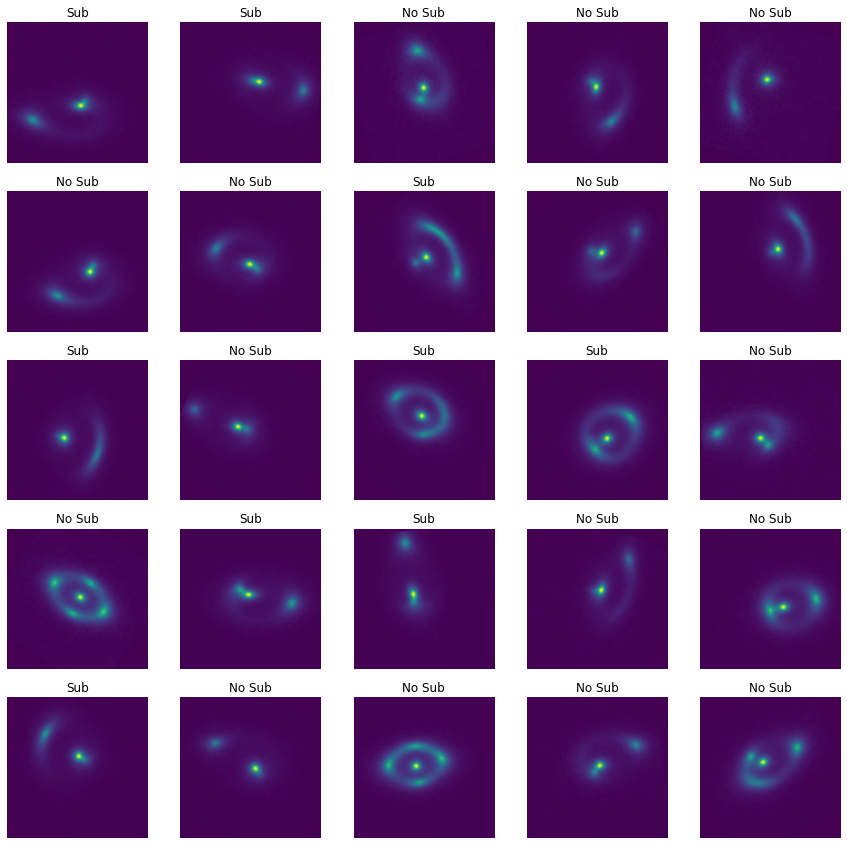

In [13]:
labels_map = {0: 'No Sub',1:'Sub'}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # im = transforms.ToPILImage()(img)
    im = img.squeeze()
    plt.imshow(im) # , cmap='gray')
plt.show()

In [14]:
# get the number of samples in train and test set
print(f"Train Data: {len(trainset)}")
print(f"Val Data: {len(valset)}")

Train Data: 9000
Val Data: 1000


In [15]:
os.makedirs("logger", exist_ok=True)

logger = create_logger(
    output_dir="logger", name="swin_tiny_patch4_window7_224"
)

In [16]:
def train_one_epoch(config, model, data_loader, optimizer, epoch, lr_scheduler):
    model.train()
    optimizer.zero_grad()

    num_steps = len(data_loader)
    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    norm_meter = AverageMeter()

    start = time.time()
    end = time.time()
    for idx, (samples_1, samples_2, targets) in enumerate(data_loader):
        samples_1 = samples_1.cuda(non_blocking=True)
        samples_2 = samples_2.cuda(non_blocking=True)
        targets = targets.cuda(non_blocking=True)

        loss = model(samples_1, samples_2)

        optimizer.zero_grad()
        if config.AMP_OPT_LEVEL != "O0":
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            if config.TRAIN.CLIP_GRAD:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), config.TRAIN.CLIP_GRAD
                )
            else:
                grad_norm = get_grad_norm(amp.master_params(optimizer))
        else:
            loss.backward()
            if config.TRAIN.CLIP_GRAD:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), config.TRAIN.CLIP_GRAD
                )
            else:
                grad_norm = get_grad_norm(model.parameters())
        optimizer.step()
        lr_scheduler.step_update(epoch * num_steps + idx)

        torch.cuda.synchronize()

        loss_meter.update(loss.item(), targets.size(0))
        norm_meter.update(grad_norm)
        batch_time.update(time.time() - end)
        end = time.time()

        if idx % config.PRINT_FREQ == 0:
            lr = optimizer.param_groups[0]["lr"]
            memory_used = torch.cuda.max_memory_allocated() / (1024.0 * 1024.0)
            etas = batch_time.avg * (num_steps - idx)
            logger.info(
                f"Train: [{epoch}/{config.TRAIN.EPOCHS}][{idx}/{num_steps}]\t"
                f"eta {datetime.timedelta(seconds=int(etas))} lr {lr:.6f}\t"
                f"time {batch_time.val:.4f} ({batch_time.avg:.4f})\t"
                f"loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t"
                f"grad_norm {norm_meter.val:.4f} ({norm_meter.avg:.4f})\t"
                f"mem {memory_used:.0f}MB"
            )
    epoch_time = time.time() - start
    logger.info(
        f"EPOCH {epoch} training takes {datetime.timedelta(seconds=int(epoch_time))}"
    )


In [17]:
def main(config, train_loader, trainset):
    dataset_train = trainset
    data_loader_train = train_loader

    config.defrost()
    config.DATA.TRAINING_IMAGES = len(dataset_train)
    config.freeze()

    logger.info(f"Creating model:{config.MODEL.TYPE}/{config.MODEL.NAME}")
    model = build_model(config)
    model.cuda()
    logger.info(str(model))

    optimizer = build_optimizer(config, model)
    if config.AMP_OPT_LEVEL != "O0":
        model, optimizer = amp.initialize(
            model, optimizer, opt_level=config.AMP_OPT_LEVEL
        )
    
    # model = torch.nn.parallel.DistributedDataParallel(
    #     model, device_ids=[config.LOCAL_RANK], broadcast_buffers=False
    # )
    model_without_ddp = model.module

    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logger.info(f"number of params: {n_parameters}")
    if hasattr(model_without_ddp, "flops"):
        flops = model_without_ddp.flops()
        logger.info(f"number of GFLOPs: {flops / 1e9}")

    lr_scheduler = build_scheduler(config, optimizer, len(data_loader_train))

    if config.TRAIN.AUTO_RESUME:
        resume_file = auto_resume_helper(config.OUTPUT)
        if resume_file:
            if config.MODEL.RESUME:
                logger.warning(
                    f"auto-resume changing resume file from {config.MODEL.RESUME} to {resume_file}"
                )
            config.defrost()
            config.MODEL.RESUME = resume_file
            config.freeze()
            logger.info(f"auto resuming from {resume_file}")
        else:
            logger.info(f"no checkpoint found in {config.OUTPUT}, ignoring auto resume")

    if config.MODEL.RESUME:
        _ = load_checkpoint(config, model_without_ddp, optimizer, lr_scheduler, logger)

    logger.info("Start self-supervised pre-training")
    start_time = time.time()
    for epoch in range(config.TRAIN.START_EPOCH, config.TRAIN.EPOCHS):
        data_loader_train.sampler.set_epoch(epoch)

        train_one_epoch(
            config, model, data_loader_train, optimizer, epoch, lr_scheduler
        )
        # if dist.get_rank() == 0 and (
        #     epoch % config.SAVE_FREQ == 0 or epoch == (config.TRAIN.EPOCHS - 1)
        # ):
        #     save_checkpoint(
        #         config, epoch, model_without_ddp, 0.0, optimizer, lr_scheduler, logger
        #     )

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    logger.info("Training time {}".format(total_time_str))


In [18]:
cfg_file = "/home/kartik/Transformer-SSL/configs/moby_swin_tiny.yaml"
config = get_config(cfg_file)
config.defrost()

=> merge config from /home/kartik/Transformer-SSL/configs/moby_swin_tiny.yaml


In [19]:
config.LOCAL_RANK

0

In [20]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

In [ ]:
os.environ["RANK"] = "1"
os.environ["WORLD_SIZE"] = "1" 
os.environ["GROUP"] = "1"
distributed_training = False

setup(rank=1, world_size=1)


In [ ]:
if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
    rank = int(os.environ["RANK"])
    world_size = int(os.environ["WORLD_SIZE"])
    print(f"RANK and WORLD_SIZE in environ: {rank}/{world_size}")
else:
    rank = -1
    world_size = -1
torch.cuda.set_device(config.LOCAL_RANK)
if distributed_training:
    torch.distributed.init_process_group(
        backend="nccl", init_method="env://", world_size=world_size, rank=rank
    )
    torch.distributed.barrier()

seed = config.SEED 
torch.manual_seed(seed)
np.random.seed(seed)
cudnn.benchmark = True

# linear scale the learning rate according to total batch size, may not be optimal
linear_scaled_lr = (
    config.TRAIN.BASE_LR * config.DATA.BATCH_SIZE / 512.0
)
linear_scaled_warmup_lr = (
    config.TRAIN.WARMUP_LR * config.DATA.BATCH_SIZE / 512.0
)
linear_scaled_min_lr = (
    config.TRAIN.MIN_LR * config.DATA.BATCH_SIZE / 512.0
)
# gradient accumulation also need to scale the learning rate
if config.TRAIN.ACCUMULATION_STEPS > 1:
    linear_scaled_lr = linear_scaled_lr * config.TRAIN.ACCUMULATION_STEPS
    linear_scaled_warmup_lr = (
        linear_scaled_warmup_lr * config.TRAIN.ACCUMULATION_STEPS
    )
    linear_scaled_min_lr = linear_scaled_min_lr * config.TRAIN.ACCUMULATION_STEPS
config.defrost()
config.TRAIN.BASE_LR = linear_scaled_lr
config.TRAIN.WARMUP_LR = linear_scaled_warmup_lr
config.TRAIN.MIN_LR = linear_scaled_min_lr
config.freeze()

os.makedirs(config.OUTPUT, exist_ok=True)
logger = create_logger(
    output_dir=config.OUTPUT, name=f"{config.MODEL.NAME}"
)

# if dist.get_rank() == 0:
path = os.path.join(config.OUTPUT, "config.json")
with open(path, "w") as f:
    f.write(config.dump())
logger.info(f"Full config saved to {path}")

# print config
logger.info(config.dump())

main(config, train_loader=train_loader, trainset=trainset)